# Library Import

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from IPython.display import display

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


# Function Imports

In [2]:
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, run, cnn_model
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_images, visualize

In [3]:
#set random seed
from numpy.random import seed
seed(1)
tf.random.set_seed(13)

# Loading in Images

In [4]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_unrealEvenish_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_uneven_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


In [5]:
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
input_shape = train_images.shape[1:]

# Unreal Photo Training Set

U5 Images: 
---------------


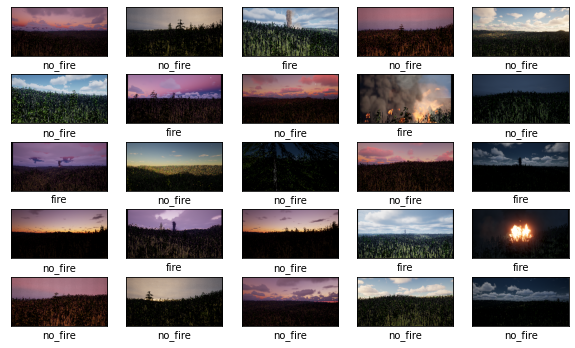

In [6]:
print('U5 Images: \n---------------')
plot_images(train_images, train_labels)

# Real Images (From Corsican (Fire) and Drone Images (on location))

Real Images (Test Data): 
---------------


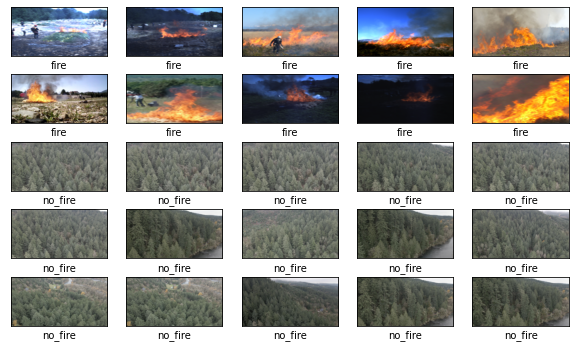

In [7]:
hold_out_images, hold_out_labels = zip(*test_data)

images_final_test = []
for img in hold_out_images:
    img = Image.fromarray(img)
    img = img.resize((input_shape[1], input_shape[0])) #change to shape of train images
    images_final_test.append(np.array(img))

hold_out_images = images_final_test
hold_out_images = np.array(hold_out_images) / 255.0
hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)

print('Real Images (Test Data): \n---------------')
plot_images(hold_out_images, hold_out_labels)

# Image Augmentation

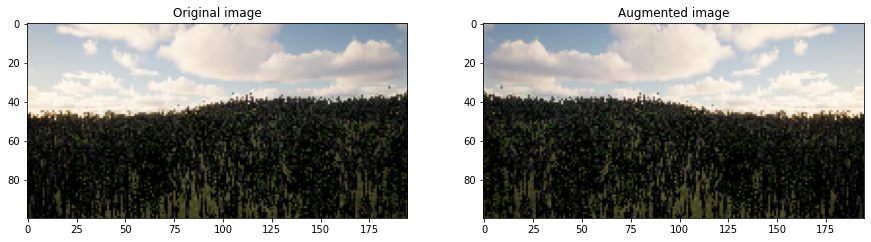

In [8]:
image = train_images[251]
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

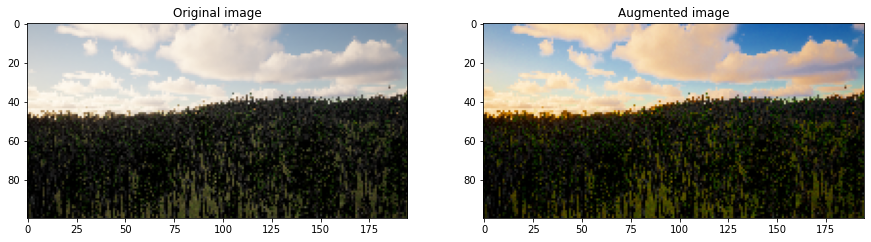

In [9]:
image = train_images[251]
augmented = tf.image.adjust_saturation(train_images[251], 3)
visualize(image, augmented)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


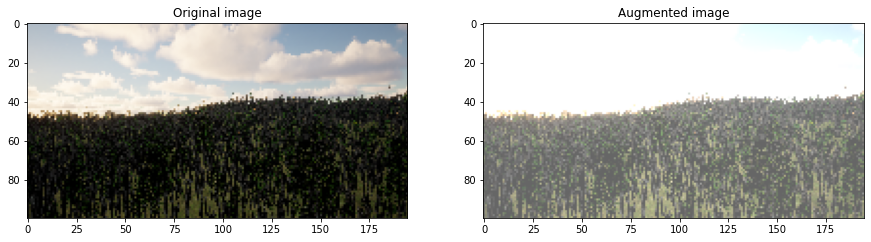

In [10]:
image = train_images[251]
augmented = tf.image.adjust_brightness(train_images[251], 0.4)
visualize(image, augmented)

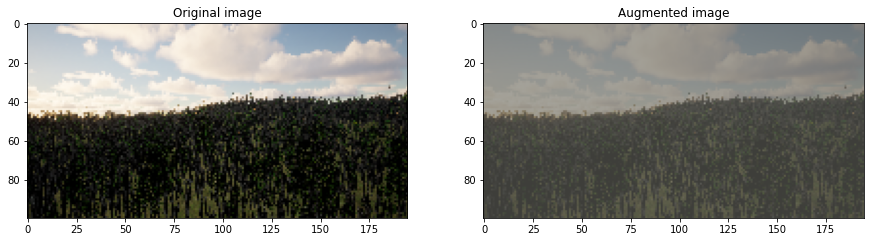

In [11]:
image = train_images[251]
augmented = tf.image.adjust_contrast(train_images[251], 0.4)
visualize(image, augmented)

# Dataset Splits

In [12]:
#view the split of the data
df = pd.DataFrame([label[0] for label in train_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['train_data_label', 'count_of_label']
df

,train_data_label,count_of_label
0,0.0,554
1,1.0,476


In [13]:
#view the split of the data
df = pd.DataFrame([label[0] for label in hold_out_labels], columns = ['label']).reset_index()
df = df.groupby('label').count().reset_index()
df.columns = ['hold_out_label', 'count_of_label']
df

,hold_out_label,count_of_label
0,0,959
1,1,10


# Model Creation

In [14]:
epochs = 3
num_units = 16
dropout_rate = 0.4
optimizer = 'RMSprop'


model, histories = cnn_model(epochs,train_images,train_labels,test_images, test_labels,
                    num_units, dropout_rate, optimizer)


Epoch 1/3
33/33 [==============================] - 71s 2s/step - loss: 0.6107 - tp: 298.0000 - fp: 157.0000 - tn: 397.0000 - fn: 178.0000 - accuracy: 0.6748 - precision: 0.6549 - recall: 0.6261 - auc: 0.7509 - prc: 0.7257 - val_loss: 0.2729 - val_tp: 48.0000 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 16.0000 - val_accuracy: 0.8760 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 0.9641 - val_prc: 0.9756
Epoch 2/3
33/33 [==============================] - 70s 2s/step - loss: 0.2230 - tp: 432.0000 - fp: 39.0000 - tn: 515.0000 - fn: 44.0000 - accuracy: 0.9194 - precision: 0.9172 - recall: 0.9076 - auc: 0.9678 - prc: 0.9734 - val_loss: 0.2418 - val_tp: 57.0000 - val_fp: 0.0000e+00 - val_tn: 65.0000 - val_fn: 7.0000 - val_accuracy: 0.9457 - val_precision: 1.0000 - val_recall: 0.8906 - val_auc: 0.9612 - val_prc: 0.9736
Epoch 3/3
33/33 [==============================] - 67s 2s/step - loss: 0.1437 - tp: 456.0000 - fp: 14.0000 - tn: 540.0000 - fn: 20.0000 - accuracy: 0.9670 - precis

In [15]:
model = tf.keras.models.load_model('artifacts/model_20201209_batch2_37.h5')

# Model Evaluation

## On Test Unreal Images

5/5 [==============================] - 2s 353ms/step


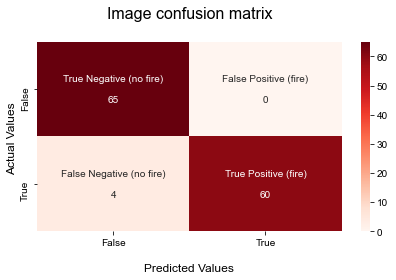

In [16]:
model.evaluate(test_images, test_labels)
predictions_probs = model.predict(test_images, verbose = 1)

scores = []
for prediction in predictions_probs:
    if prediction >= .75:
        scores.append(1)
    else:
        scores.append(0)

confusion_matrix
plot_confusion_matrix_2(confusion_matrix(y_true=test_labels, y_pred=scores),normalize=False)

# On Real Images (Drone and Fire Images from Corsican)

31/31 [==============================] - 13s 393ms/step


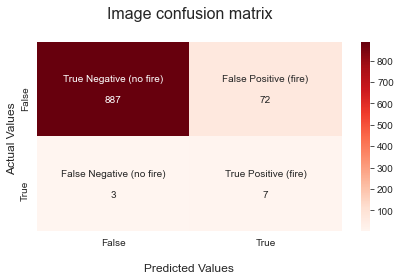

In [17]:
#model.evaluate(hold_out_images, hold_out_labels)
predictions_probs = model.predict(hold_out_images, verbose = 1)

scores = []
for prediction in predictions_probs:
    if prediction >= .75:
        scores.append(1)
    else:
        scores.append(0)

confusion_matrix
plot_confusion_matrix_2(confusion_matrix(y_true=hold_out_labels, y_pred=scores),normalize=False)

# ROC/AUC

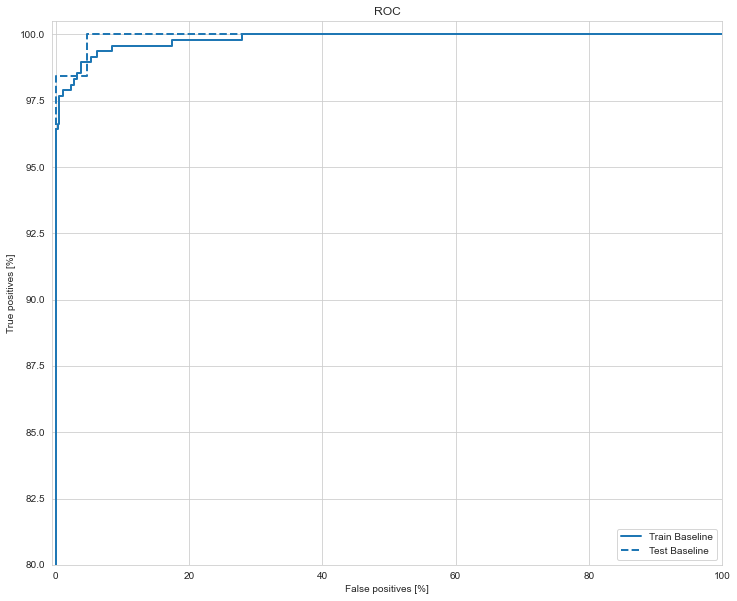

In [18]:
train_predictions_baseline = model.predict(train_images)
test_predictions_baseline = model.predict(test_images)

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([80,100.5])
  plt.title('ROC')
  plt.grid(True)
  ax = plt.gca()
  #ax.set_aspect('equal')


plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

## Other Performence Metrics

In [19]:
line_chart(histories[0])

,epoch,variable,value
0,0,accuracy,0.674757
1,1,accuracy,0.919418
2,2,accuracy,0.966990
3,0,precision,0.654945
4,1,precision,0.917197


alt.Chart(...)